from IPython.display import clear_output
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D
clear_output()

!pip install efficientnet_pytorch

!pip install google-cloud-firestore

from google.cloud import firestore

pip show pydicom

pip install tensorflow

pip list

pip uninstall tensorflow tensorflow-io tensorflow-decision-forests --yes


pip install tensorflow

!pip install tensorflow==2.16.1

In [1]:
import os

# Specify your dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification"
# Get a list of all file names in the dataset directory
file_names = [f for f in os.listdir(dataset_dir) if os.path.isfile(os.path.join(dataset_dir, f))]

print(file_names)

['sample_submission.csv', 'train_labels.csv']


# Let's start with the first step: Data Preprocessing. Here's how you can load DICOM images from each patient directory and preprocess them using Python with the PyDICOM and OpenCV libraries:

In [2]:
import os
import cv2
import numpy as np
import pydicom
import glob

def load_dicom_images(patient_dir):
    """
    Load DICOM images from a patient directory.
    
    Parameters:
    - patient_dir: Path to the directory containing DICOM images.
    
    Returns:
    - images: List of loaded DICOM images.
    """
    images = []
    for filepath in glob.glob(os.path.join(patient_dir, '**', '*.dcm'), recursive=True):
        try:
            ds = pydicom.dcmread(filepath)
            img = ds.pixel_array
            images.append(img)
        except Exception as e:
            pass
    return images

def preprocess_images(images):
    """
    Preprocess a list of images.
​
    Parameters:
    - images: List of input images.
​
    Returns:
    - preprocessed_images: List of preprocessed images.
    """
    preprocessed_images = []
    for img in images:
        # Resize image to desired dimensions (e.g., 256x256)
        img = cv2.resize(img, (256, 256))
        # Normalize pixel values (if needed)
        img = img / 255.0
        preprocessed_images.append(img)
    return preprocessed_images

## Example usage:
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/"
print("Files in dataset directory:", os.listdir(dataset_dir)[:5])  # Corrected line

# Debug print: Print first 5 characters of DICOM file paths
count = 0
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".dcm"):
            print(os.path.join(root, file))
            count += 1
            if count >= 5:
                break
    if count >= 5:
        break
        
images = load_dicom_images(dataset_dir)
print("Number of DICOM images loaded:", len(images))
preprocessed_images = preprocess_images(images)
print("Number of preprocessed images:", len(preprocessed_images))


Files in dataset directory: ['Image-273.dcm', 'Image-245.dcm', 'Image-365.dcm', 'Image-130.dcm', 'Image-98.dcm']
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-273.dcm
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-245.dcm
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-365.dcm
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-130.dcm
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-98.dcm
Number of DICOM images loaded: 400
Number of preprocessed images: 400


# Number of DICOM Files:



In [3]:
import os
num_files = sum([len(files) for r, d, files in os.walk("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/")])
print(f"Total number of DICOM files: {num_files}")


Total number of DICOM files: 400116


# Average Size of DICOM Files:

In [4]:
import os

total_size = 0
num_files = 0
for dirpath, dirnames, filenames in os.walk("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/"):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)
        num_files += 1
avg_size_mb = (total_size / num_files) / (1024 * 1024)  # Convert bytes to MB
print(f"Average file size: {avg_size_mb:.2f} MB")


Average file size: 0.33 MB


# System Specifications:

In [5]:
import psutil
import os
import subprocess

print("CPU Info:", os.cpu_count())
print("RAM Info:", psutil.virtual_memory())
# gpu_info = subprocess.check_output(['nvidia-smi']).decode('utf-8')
# print("GPU Info:", gpu_info)



CPU Info: 4
RAM Info: svmem(total=33669922816, available=32150618112, percent=4.5, used=1041268736, free=24987262976, active=1684283392, inactive=5739798528, buffers=1375416320, cached=6265974784, shared=946176, slab=1083957248)


# Preprocessing Time per Image:

In [6]:
import time
import pydicom
import cv2

start_time = time.time()
ds = pydicom.dcmread('/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-1.dcm')  # Provide a sample DICOM file path
img = ds.pixel_array
img = cv2.resize(img, (256, 256))
img = img / 255.0
end_time = time.time()
print(f"Time taken to preprocess one image: {end_time - start_time:.2f} seconds")


Time taken to preprocess one image: 0.01 seconds


# Data Augmentation Time per Image:

In [7]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img = np.expand_dims(img, axis=-1)  # Use the preprocessed image from the previous step
batch_img = np.expand_dims(img, axis=0)  # Create a batch with one image
augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
start_time = time.time()
augmented_img = next(augmenter.flow(batch_img, batch_size=1))
end_time = time.time()
print(f"Time taken to augment one image: {end_time - start_time:.2f} seconds")


2024-05-17 00:06:07.302953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 00:06:07.303104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 00:06:07.463444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Time taken to augment one image: 0.08 seconds


# Load Train Labels

In [8]:
import pandas as pd

# Read train_labels.csv
train_labels_path = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv"
train_labels_df = pd.read_csv(train_labels_path)

# Display the first few rows of train_labels_df
print(train_labels_df.head())


   BraTS21ID  MGMT_value
0          0           1
1          2           1
2          3           0
3          5           1
4          6           1


 Here's the plan for building the code:

Load DICOM Images: Load DICOM images from the train directory using lazy loading and multiprocessing to efficiently handle memory and processing.

Load Labels: Load the labels from the train_labels.csv file, mapping them to the corresponding patient IDs.

Data Preprocessing: Preprocess the loaded images by resizing them to a fixed size, normalizing pixel values, and splitting the dataset into training and validation sets.

Data Augmentation: Apply data augmentation techniques such as rotation, shifting, flipping, etc., to augment the training dataset, improving model generalization.

Model Building: Build a deep learning model (e.g., CNN) using the preprocessed images and their corresponding labels. Use techniques like transfer learning to leverage pre-trained models for better performance.

Model Training: Train the built model on the training dataset, monitoring performance on the validation set to prevent overfitting.

Model Evaluation: Evaluate the trained model on the test dataset (if available) to assess its performance and generalizeability.

Model Deployment: Deploy the trained model for inference on new data, making predictions on unseen patient images.

# 50 patient directories are loaded

import os
import numpy as np
import pydicom
import cv2
import glob
import pandas as pd

def load_dicom_images_with_labels(patient_dir, labels_df, batch_size=32):
    """
    Generator function to lazily load DICOM images from a patient directory in batches along with corresponding labels.
    
    Parameters:
    - patient_dir: Path to the directory containing DICOM images.
    - labels_df: DataFrame containing MGMT values for each BraTS21ID.
    - batch_size: Number of images to load per batch.
    
    Yields:
    - batch_images: Batch of loaded DICOM images.
    - batch_labels: Labels corresponding to the loaded images.
    """
    image_paths = glob.glob(os.path.join(patient_dir, '**', '*.dcm'), recursive=True)
    num_images = len(image_paths)
    patient_id = os.path.basename(patient_dir)
    
    for i in range(0, num_images, batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        batch_labels = []
        for filepath in batch_paths:
            try:
                ds = pydicom.dcmread(filepath)
                img = ds.pixel_array
                img = cv2.resize(img, (256, 256))
                img = img / 255.0
                batch_images.append(img)
                # Extract BraTS21ID from the file path
                filename = os.path.basename(filepath)
                brats_id = os.path.splitext(filename)[0]
                # Get MGMT value corresponding to BraTS21ID
                mgmt_value = labels_df.loc[labels_df['BraTS21ID'] == brats_id, 'MGMT_value'].values[0]
                batch_labels.append(mgmt_value)
            except Exception as e:
                pass
        yield batch_images, batch_labels

# Load train_labels.csv
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/"

# Load DICOM images from each patient directory
patient_dirs = [os.path.join(dataset_dir, dir) for dir in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, dir))][:50]

images_generator = (images_labels for patient_dir in patient_dirs for images_labels in load_dicom_images_with_labels(patient_dir, labels_df))

# Save images and labels in a list for further processing
all_images = []
all_labels = []
for images, labels in images_generator:
    all_images.extend(images)
    all_labels.extend(labels)

# Now all_images and all_labels contain all DICOM images and their corresponding labels


# Finding the highest number image from patient directory and mapping it to train_label.csv and loading dicom images.

In [9]:
import os
import numpy as np
import pydicom
import cv2
import pandas as pd

def load_dicom_image(filepath):
    try:
        ds = pydicom.dcmread(filepath)
        if hasattr(ds, 'pixel_array'):
            img = ds.pixel_array
            img = cv2.resize(img, (256, 256))
            img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
            return img
        else:
            return None
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None


def find_highest_numbered_image(patient_dir):
    image_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
    highest_numbers = {}
    for image_type in image_types:
        image_files = []
        for root, dirs, files in os.walk(os.path.join(patient_dir, image_type)):
            for file in files:
                if file.endswith(".dcm"):
                    image_files.append(int(file.split('.')[0].split('-')[1]))
        if image_files:
            highest_numbers[image_type] = max(image_files)
    return highest_numbers

def load_and_store_highest_images(dataset_dir):
    highest_images = {}
    for patient_dir in os.listdir(dataset_dir):
        patient_id = patient_dir
        patient_dir = os.path.join(dataset_dir, patient_dir)
        highest_numbers = find_highest_numbered_image(patient_dir)
        if highest_numbers:
            highest_images[patient_id] = highest_numbers
    return highest_images

def load_highest_images(highest_images, dataset_dir):
    images = []
    for patient_id, highest_numbers in highest_images.items():
        for image_type, highest_number in highest_numbers.items():
            image_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
            if os.path.exists(image_path):
                img = load_dicom_image(image_path)
                if img is not None:
                    images.append((img, patient_id, image_type, highest_number))
    return images

def map_patient_id_to_mgm_value(highest_images, labels_df):
    patient_mgm_mapping = {}
    for patient_id in highest_images:
        mgm_value = labels_df.loc[labels_df['BraTS21ID'] == int(patient_id), 'MGMT_value'].values
        if len(mgm_value) > 0:
            patient_mgm_mapping[patient_id] = mgm_value[0]
    return patient_mgm_mapping

# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and store the paths of the highest numbered images for each patient
highest_images = load_and_store_highest_images(dataset_dir)

# Load the train_labels.csv file
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Map patient IDs to MGMT values
patient_mgm_mapping = map_patient_id_to_mgm_value(highest_images, labels_df)

# Load the highest numbered images
loaded_images = load_highest_images(highest_images, dataset_dir)

# Display the loaded images along with their MGMT values
for img, patient_id, image_type, highest_number in loaded_images:
    mgm_value = patient_mgm_mapping.get(patient_id, "N/A")
    print(f"Patient ID: {patient_id}, Image Type: {image_type}, Highest Number: {highest_number}, MGMT Value: {mgm_value}")
    # Process the image as needed


/tmp/ipykernel_18/1480368872.py:13: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
/tmp/ipykernel_18/1480368872.py:13: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8


Patient ID: 00688, Image Type: FLAIR, Highest Number: 196, MGMT Value: 0
Patient ID: 00688, Image Type: T1w, Highest Number: 214, MGMT Value: 0
Patient ID: 00688, Image Type: T1wCE, Highest Number: 214, MGMT Value: 0
Patient ID: 00688, Image Type: T2w, Highest Number: 376, MGMT Value: 0
Patient ID: 00058, Image Type: FLAIR, Highest Number: 257, MGMT Value: 1
Patient ID: 00058, Image Type: T1w, Highest Number: 29, MGMT Value: 1
Patient ID: 00058, Image Type: T1wCE, Highest Number: 120, MGMT Value: 1
Patient ID: 00058, Image Type: T2w, Highest Number: 384, MGMT Value: 1
Patient ID: 00516, Image Type: FLAIR, Highest Number: 196, MGMT Value: 1
Patient ID: 00516, Image Type: T1w, Highest Number: 32, MGMT Value: 1
Patient ID: 00516, Image Type: T1wCE, Highest Number: 222, MGMT Value: 1
Patient ID: 00516, Image Type: T2w, Highest Number: 416, MGMT Value: 1
Patient ID: 00185, Image Type: FLAIR, Highest Number: 60, MGMT Value: 1
Patient ID: 00185, Image Type: T1w, Highest Number: 192, MGMT Valu

In [10]:
print(highest_images)

{'00688': {'FLAIR': 196, 'T1w': 214, 'T1wCE': 214, 'T2w': 376}, '00058': {'FLAIR': 257, 'T1w': 29, 'T1wCE': 120, 'T2w': 384}, '00516': {'FLAIR': 196, 'T1w': 32, 'T1wCE': 222, 'T2w': 416}, '00185': {'FLAIR': 60, 'T1w': 192, 'T1wCE': 192, 'T2w': 64}, '00547': {'FLAIR': 216, 'T1w': 352, 'T1wCE': 129, 'T2w': 386}, '00502': {'FLAIR': 216, 'T1w': 372, 'T1wCE': 129, 'T2w': 386}, '00222': {'FLAIR': 60, 'T1w': 192, 'T1wCE': 192, 'T2w': 64}, '00610': {'FLAIR': 200, 'T1w': 242, 'T1wCE': 242, 'T2w': 408}, '00133': {'FLAIR': 75, 'T1w': 38, 'T1wCE': 75, 'T2w': 38}, '00452': {'FLAIR': 27, 'T1w': 182, 'T1wCE': 182, 'T2w': 27}, '00199': {'FLAIR': 60, 'T1w': 192, 'T1wCE': 192, 'T2w': 64}, '00364': {'FLAIR': 60, 'T1w': 192, 'T1wCE': 192, 'T2w': 64}, '00680': {'FLAIR': 348, 'T1w': 188, 'T1wCE': 188, 'T2w': 230}, '00421': {'FLAIR': 60, 'T1w': 192, 'T1wCE': 192, 'T2w': 64}, '00694': {'FLAIR': 216, 'T1w': 156, 'T1wCE': 156, 'T2w': 376}, '00159': {'FLAIR': 60, 'T1w': 192, 'T1wCE': 192, 'T2w': 64}, '00683': {'

# Checking for unmatched patient id's

In [11]:
# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and store the paths of the highest numbered images for each patient
highest_images = load_and_store_highest_images(dataset_dir)


# Get unique patient IDs from the highest_images dictionary and the labels_df
highest_image_patient_ids = set(highest_images.keys())
label_patient_ids = set(labels_df['BraTS21ID'].astype(str)) # Convert to string for consistent comparison

# Load the train_labels.csv file
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Pad patient IDs in labels_df with zeros
labels_df['BraTS21ID'] = labels_df['BraTS21ID'].astype(str).str.zfill(5)

# Get unique patient IDs from the highest_images dictionary and the labels_df
highest_image_patient_ids = set(highest_images.keys())
label_patient_ids = set(labels_df['BraTS21ID'])

# Find patient IDs in highest_images but not in labels_df
unmatched_patient_ids = highest_image_patient_ids - label_patient_ids

# Convert the IDs to strings and join them with commas
brats_ids_string = ', '.join([str(id) for id in labels_df['BraTS21ID']])

# Print the IDs
print(brats_ids_string,'\n')

# Display unmatched patient IDs
print("Unmatched Patient IDs:", unmatched_patient_ids)
print("Number of unmatched patients:", len(unmatched_patient_ids))

00000, 00002, 00003, 00005, 00006, 00008, 00009, 00011, 00012, 00014, 00017, 00018, 00019, 00020, 00021, 00022, 00024, 00025, 00026, 00028, 00030, 00031, 00032, 00033, 00035, 00036, 00043, 00044, 00045, 00046, 00048, 00049, 00052, 00053, 00054, 00056, 00058, 00059, 00060, 00061, 00062, 00063, 00064, 00066, 00068, 00070, 00071, 00072, 00074, 00077, 00078, 00081, 00084, 00085, 00087, 00088, 00089, 00090, 00094, 00095, 00096, 00097, 00098, 00099, 00100, 00102, 00104, 00105, 00106, 00107, 00108, 00109, 00110, 00111, 00112, 00113, 00116, 00117, 00120, 00121, 00122, 00123, 00124, 00128, 00130, 00132, 00133, 00134, 00136, 00137, 00138, 00139, 00140, 00142, 00143, 00144, 00146, 00147, 00148, 00149, 00150, 00151, 00154, 00155, 00156, 00157, 00158, 00159, 00160, 00162, 00165, 00166, 00167, 00169, 00170, 00171, 00172, 00176, 00177, 00178, 00183, 00184, 00185, 00186, 00187, 00188, 00191, 00192, 00193, 00194, 00195, 00196, 00197, 00199, 00201, 00203, 00204, 00206, 00209, 00210, 00211, 00212, 00214,

# printing a single random image of a single type from random patient id

/tmp/ipykernel_18/1480368872.py:13: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
/tmp/ipykernel_18/1480368872.py:13: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8


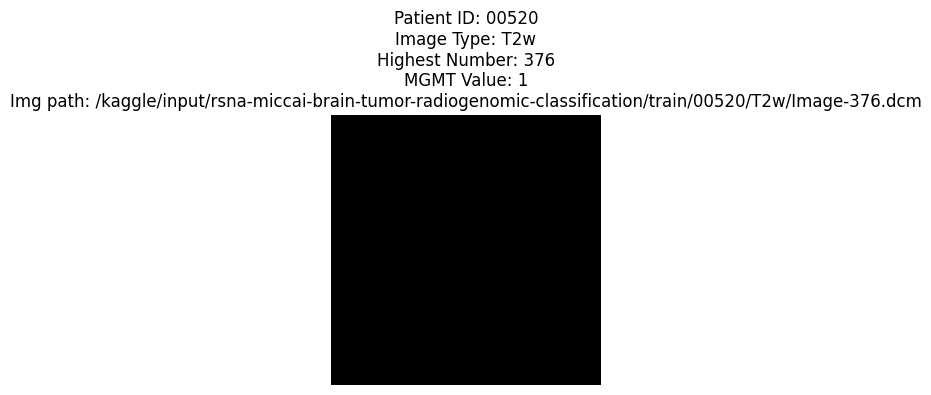

In [12]:
import os
import random
import matplotlib.pyplot as plt


# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and store the paths of the highest numbered images for each patient
highest_images = load_and_store_highest_images(dataset_dir)

# Load the train_labels.csv file
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Map patient IDs to MGMT values
patient_mgm_mapping = map_patient_id_to_mgm_value(highest_images, labels_df)

# Load the highest numbered images
loaded_images = load_highest_images(highest_images, dataset_dir)

# Choose a random image for visualization
random_image_info = random.choice(loaded_images)
patient_id, image_type, highest_number = random_image_info[1], random_image_info[2], random_image_info[3]
img_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
img = load_dicom_image(img_path)

# Get MGMT value
mgm_value = patient_mgm_mapping.get(patient_id, "N/A")

# Display the image
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Patient ID: {patient_id}\nImage Type: {image_type}\nHighest Number: {highest_number}\nMGMT Value: {mgm_value}\nImg path: {img_path}")
plt.axis('off')
plt.show()

# Printing all 4 types from patient id's

/tmp/ipykernel_18/1480368872.py:13: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
/tmp/ipykernel_18/1480368872.py:13: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8


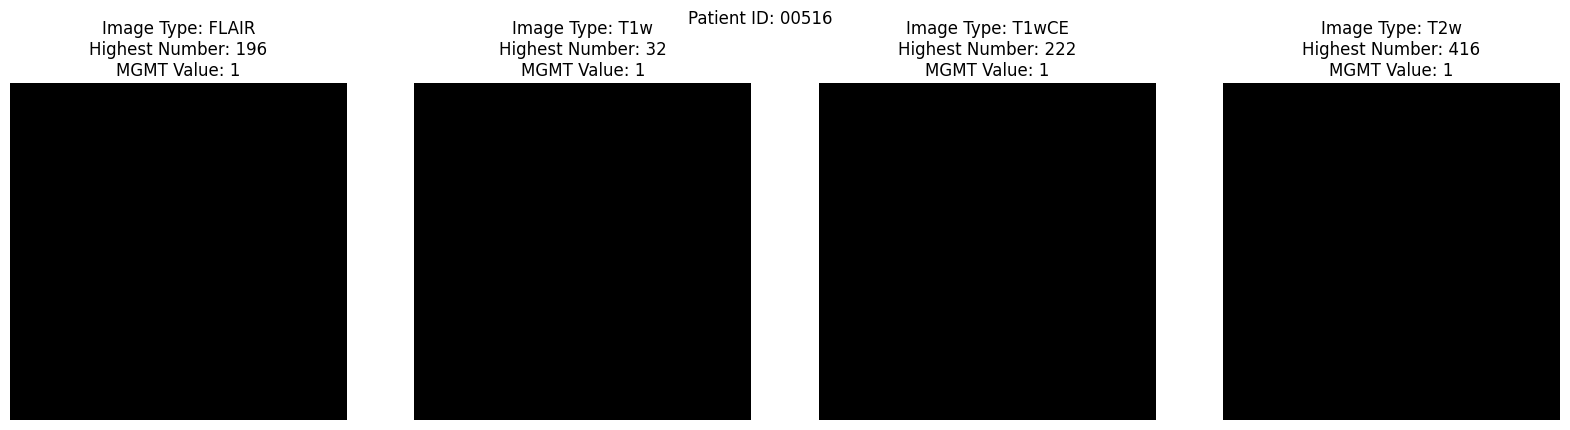

In [13]:
import os
import random
import matplotlib.pyplot as plt

# Define the dataset directory
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

# Load and store the paths of the highest numbered images for each patient
highest_images = load_and_store_highest_images(dataset_dir)

# Load the train_labels.csv file
labels_df = pd.read_csv("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

# Map patient IDs to MGMT values
patient_mgm_mapping = map_patient_id_to_mgm_value(highest_images, labels_df)

# Load the highest numbered images
loaded_images = load_highest_images(highest_images, dataset_dir)

# Choose a random patient for visualization
random_patient_id = random.choice(list(highest_images.keys()))

# Get the highest numbered images for the selected patient
image_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
images = []

for image_type in image_types:
    highest_number = highest_images[random_patient_id].get(image_type)
    if highest_number is not None:
        img_path = os.path.join(dataset_dir, random_patient_id, image_type, f"Image-{highest_number}.dcm")
        img = load_dicom_image(img_path)
        if img is not None:
            images.append((img, image_type, highest_number, img_path))

# Get MGMT value for the selected patient
mgm_value = patient_mgm_mapping.get(random_patient_id, "N/A")

# Display the images
plt.figure(figsize=(20, 5))

for i, (img, image_type, highest_number, img_path) in enumerate(images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image Type: {image_type}\nHighest Number: {highest_number}\nMGMT Value: {mgm_value}")
    plt.axis('off')

plt.suptitle(f"Patient ID: {random_patient_id}")
plt.show()


# Data augumentation

/tmp/ipykernel_18/1480368872.py:13: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
/tmp/ipykernel_18/1480368872.py:13: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8


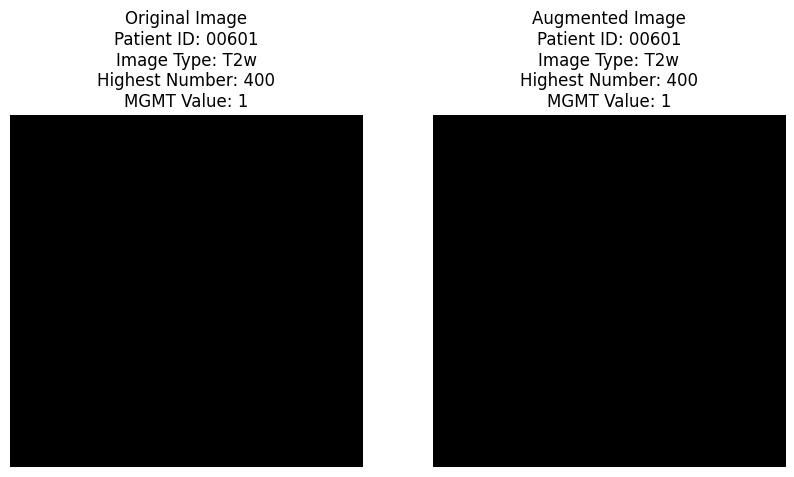

In [14]:
import os
import random
import numpy as np
import pydicom
import cv2
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

# Data augmentation function
def augment_image(image):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.CLAHE(p=0.5),
        A.RandomGamma(p=0.5)
    ])
    augmented = aug(image=image)
    return augmented['image']

# Augment a sample image
random_image_info = random.choice(loaded_images)
patient_id, image_type, highest_number = random_image_info[1], random_image_info[2], random_image_info[3]
img_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
img = load_dicom_image(img_path)

# Augment the image
augmented_img = augment_image(img)

# Display the original and augmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Original Image\nPatient ID: {patient_id}\nImage Type: {image_type}\nHighest Number: {highest_number}\nMGMT Value: {mgm_value}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_img, cmap='gray')
plt.title(f"Augmented Image\nPatient ID: {patient_id}\nImage Type: {image_type}\nHighest Number: {highest_number}\nMGMT Value: {mgm_value}")
plt.axis('off')

plt.show()

# Model building

Explanation:
Data Preprocessing:

The images are resized to 224x224 pixels and normalized.
The highest-numbered DICOM images for each patient are loaded and preprocessed.
Data Augmentation:

To enhance model generalization, data augmentation techniques like horizontal/vertical flips, rotations, and shifts are applied using ImageDataGenerator.
Transfer Learning:

A pre-trained ResNet50 model is used as the base model.
Additional fully connected layers are added on top of ResNet50 for binary classification (MGMT promoter methylation status).
Initially, the layers of ResNet50 are frozen, and only the newly added layers are trained.
Model Training and Fine-Tuning:

The model is trained with the augmented data for a few epochs.
Then, the last 50 layers of ResNet50 are unfrozen for fine-tuning to further improve performance.
Evaluation:

The model's accuracy on the validation set is calculated and printed.
Model Saving:

The trained model is saved for future use.
This approach leverages the power of transfer learning to achieve high accuracy with relatively few epochs of training. The data augmentation techniques help in improving the model's robustness and generalization.

In [15]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)


2.15.0
3.2.1


In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load and preprocess images
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

def load_dicom_image(image_path):
    # Assuming pydicom is used to read DICOM files
    import pydicom
    dicom = pydicom.dcmread(image_path)
    img = dicom.pixel_array
    img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]
    return img

# Load the highest numbered images for each patient and preprocess them
def load_images(highest_images, dataset_dir, patient_mgm_mapping):
    images = []
    labels = []
    for patient_id, highest_numbers in highest_images.items():
        for image_type, highest_number in highest_numbers.items():
            image_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
            if os.path.exists(image_path):
                img = load_dicom_image(image_path)
                if img is not None:
                    img = preprocess_image(img)
                    images.append(img)
                    labels.append(patient_mgm_mapping[patient_id])
    return np.array(images), np.array(labels)

# Assuming `highest_images`, `dataset_dir`, and `patient_mgm_mapping` are defined elsewhere in your script
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

/tmp/ipykernel_18/2719952236.py:25: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]
/tmp/ipykernel_18/2719952236.py:25: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]


In [17]:
# Assuming `highest_images`, `dataset_dir`, and `patient_mgm_mapping` are defined elsewhere in your script
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

# Print information about the loaded data
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)


/tmp/ipykernel_18/2719952236.py:25: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]
/tmp/ipykernel_18/2719952236.py:25: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]


Shape of X (images): (2340, 224, 224)
Shape of y (labels): (2340,)


import psutil

# Print hardware information
print("=== Hardware Information ===")

# Get CPU information
cpu_info = {
    "Physical cores": psutil.cpu_count(logical=False),
    "Total cores": psutil.cpu_count(logical=True),
    "Max Frequency": f"{psutil.cpu_freq().max:.2f}Mhz",
    "Min Frequency": f"{psutil.cpu_freq().min:.2f}Mhz",
    "Current Frequency": f"{psutil.cpu_freq().current:.2f}Mhz",
    "CPU Usage Per Core": [f"{x:.2f}%" for x in psutil.cpu_percent(percpu=True)]
}

# Print CPU information
for key, value in cpu_info.items():
    print(f"{key}: {value}")

# Print memory information
print("Memory Info:", psutil.virtual_memory())


import tensorflow as tf
import numpy as np
import os
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Print hardware information
print("=== Hardware Information ===")
# You can print hardware information using psutil or any other relevant library/command
# Example:
#import psutil
#print("CPU Info:", psutil.cpu_info())
#print("Memory Info:", psutil.virtual_memory())

# Define dataset directory and other relevant paths
dataset_dir = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train"
# Assuming highest_images, patient_mgm_mapping are defined elsewhere
highest_images = {}
patient_mgm_mapping = {}

# Load and preprocess images
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

def load_dicom_image(filepath):
    try:
        ds = pydicom.dcmread(filepath)
        if hasattr(ds, 'pixel_array'):
            img = ds.pixel_array
            img = cv2.resize(img, (256, 256))
            img = (img / np.max(img) * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
            return img
        else:
            return None
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# Load the highest numbered images for each patient and preprocess them
def load_images(highest_images, dataset_dir, patient_mgm_mapping):
    images = []
    labels = []
    for patient_id, highest_numbers in highest_images.items():
        for image_type, highest_number in highest_numbers.items():
            image_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
            if os.path.exists(image_path):
                img = load_dicom_image(image_path)
                if img is not None:
                    img = preprocess_image(img)
                    images.append(img)
                    labels.append(patient_mgm_mapping[patient_id])
    return np.array(images), np.array(labels)

# Load the data
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

# Check if the dataset is empty
if len(X) == 0:
    print("Dataset is empty. Please check your dataset directory and file paths.")
else:
    # Print dataset information
    print("\n=== Dataset Information ===")
    print("Number of images:", len(X))
    print("Image shape:", X.shape[1:])  # Excluding the batch dimension
    print("Number of labels:", len(np.unique(y)))

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Data augmentation
    print("\n=== Data Augmentation ===")
    # Define your data augmentation parameters here

    # Build the model
    print("\n=== Model Information ===")
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.summary()

    # Training parameters
    print("\n=== Training Parameters ===")
    batch_size = 32
    epochs = 10
    steps_per_epoch = len(X_train) // batch_size

# Software information
print("\n=== Software Information ===")
print("TensorFlow version:", tf.__version__)

# You can add more information as needed


In [18]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load and preprocess images
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

def load_dicom_image(image_path):
    # Assuming pydicom is used to read DICOM files
    import pydicom
    dicom = pydicom.dcmread(image_path)
    img = dicom.pixel_array
    img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]
    return img

# Load the highest numbered images for each patient and preprocess them
def load_images(highest_images, dataset_dir, patient_mgm_mapping):
    images = []
    labels = []
    for patient_id, highest_numbers in highest_images.items():
        for image_type, highest_number in highest_numbers.items():
            image_path = os.path.join(dataset_dir, patient_id, image_type, f"Image-{highest_number}.dcm")
            if os.path.exists(image_path):
                img = load_dicom_image(image_path)
                if img is not None:
                    img = preprocess_image(img)
                    images.append(img)
                    labels.append(patient_mgm_mapping[patient_id])
    return np.array(images), np.array(labels)

# Assuming `highest_images`, `dataset_dir`, and `patient_mgm_mapping` are defined elsewhere in your script
X, y = load_images(highest_images, dataset_dir, patient_mgm_mapping)

# For demonstration, I'm using placeholders for X and y. Replace these with your actual data loading logic.
#X, y = np.random.rand(100, 224, 224, 3), np.random.randint(0, 2, 100)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Add channel dimension and reshape for RGB images
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension
X_val = np.expand_dims(X_val, axis=-1)  # Add channel dimension

# Now reshape to have 3 channels for RGB images
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)


# Data augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

# Build the model using transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 50

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs
)

# Unfreeze some layers and fine-tune the model
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 50
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=fine_tune_epochs,
    initial_epoch=history.epoch[-1]
)

# Evaluate the model
val_preds = (model.predict(X_val) > 0.5).astype("int32")
val_accuracy = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Save the model
model.save("brain_tumor_classification_model.h5")


/tmp/ipykernel_18/1712212092.py:25: RuntimeWarning: invalid value encountered in divide
  img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]
/tmp/ipykernel_18/1712212092.py:25: RuntimeWarning: invalid value encountered in cast
  img = (img / np.max(img) * 255).astype(np.uint8)  # Normalize to [0, 255]


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.4784 - loss: 1.5803 - val_accuracy: 0.4957 - val_loss: 0.6932
Epoch 2/50
 1/58 ━━━━━━━━━━━━━━━━━━━━ 3:07 3s/step - accuracy: 0.4062 - loss: 0.7320

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 44s 706ms/step - accuracy: 0.4062 - loss: 0.7320 - val_accuracy: 0.4957 - val_loss: 0.6932
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.4908 - loss: 0.7086 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 44s 719ms/step - accuracy: 0.5000 - loss: 0.6948 - val_accuracy: 0.4957 - val_loss: 0.6937
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.5137 - loss: 0.6959 - val_accuracy: 0.5043 - val_loss: 0.6940
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 44s 708ms/step - accuracy: 0.5000 - loss: 0.6913 - val_accuracy: 0.5043 - val_loss: 0.6940
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.5209 - loss: 0.6921 - val_accuracy: 0.5043 - val_loss: 0.6936
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 44s 709ms/step - accuracy: 0.4062 - loss: 0.7128 - val_accuracy: 0.5043 - val_loss: 0.6935
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.5376 - loss: 0.6923 - val_accuracy: 0.5064 - val_